In [1]:
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.cross_validation import StratifiedKFold
from keras.utils import np_utils

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import svm

import h5py as h5
import numpy as np
import time

import config
import util

fold_count = 1

# Save deep features CNN for svm classification
def save_bottlebeck_features(X_train, X_test, y_train, y_test, pretrained_weights):
    model = util.load_svm_alex_model(nb_class=config.nb_class, weights_path=pretrained_weights)

    bottleneck_features_train = model.predict(X_train)
    np.save(open('alex_bottleneck_features_train' + str(fold_count) + '.npy', 'wb'), bottleneck_features_train)

    bottleneck_features_validation = model.predict(X_test)
    np.save(open('alex_bottleneck_features_validation' + str(fold_count) + '.npy', 'wb'), bottleneck_features_validation)
    print "Deep features extracted ", bottleneck_features_train.shape[1:]

def train_svm(y_train, y_test):
    X_train = np.load(open('alex_bottleneck_features_train' + str(fold_count) + '.npy' , 'rb'))
    X_test = np.load(open('alex_bottleneck_features_validation' + str(fold_count) + '.npy', 'rb'))
    
    print "\nTraining SVM.."
    clf = svm.SVC(kernel='linear', probability=True)
    clf.fit(X_train, y_train.ravel())
    score = clf.score(X_test, y_test.ravel())
    print("SVM %s: %.2f%%" % ("acc: ", score*100))
    
    y_pred = clf.predict(X_test)
    target_names = ["Murukku","MeeHoonKueh","BuburPedas","Nasikandar","Mangosteen","KuihDadar","BingkaUbi","CharSiu","Sataycelup",
    "Kangkung","Cendol","SeriMuka","CheeCheongFun","Bakkukteh","Chweekueh","KuihLapis","DurianCrepe",
    "Lemang","OysterOmelette","AngKuKueh","RotiJohn","Huatkuih","PisangGoreng","CurryPuff","TomYumSoup",
    "LorMee","PrawnMee","Wonton","MeeGoreng","IkanBakar","Wajik","AisKacang","Nasipattaya","Keklapis","ChaiTowKuay",
    "SambalUdang","Puri","Lekor","PutuPiring","Murtabak","Buburchacha","Asamlaksa","TangYuan","NasiGorengKampung",
    "PutuMayam","PineappleTart","Bazhang","MeeSiam","Satay","CharKuehTiao","Thosai","Bahulu","Youtiao","Otakotak","Guava",
    "FishHeadCurry","Dodol","LepatPisang","Ketupat","YongTauFu","Yusheng","TauhuSumbat","TauFooFah","HokkienMee","BeefRendang",
    "Prawnsambal","NasiImpit","SambalPetai","CucurUdang","RotiCanai","Durian","KayaToast","MeeRebus","ApamBalik","BananaLeafRice",
    "Capati","Popiah","ClayPotRice","WaTanHo","MeeJawa","RotiNaan","KuihSeriMuka","ChiliCrab","HainaneseChickenRice","Rambutan","Nasilemak",
    "PanMee","WanTanMee","OndehOndeh","CurryLaksa","MaggiGoreng","RotiTissue","Rojak","TandooriChicken","MeeRojak","SotoAyam","MeeHoonSoup",
    "Langsat","YamCake","RotiJala"]
    cm = confusion_matrix(y_test, y_pred)
    util.plot_confusion_matrix(cm)
    #plt.savefig('cm_deep_feaures'+ str(fold_count) +'.png', dpi=300, aspect='auto')
    plt.show()
    plt.gcf().clear()
    f1_score(y_test, y_pred,average=None)
    print(classification_report(y_test, y_pred,target_names=target_names))
      
    #scores = clf.decision_function(X_test)
      # Get Top-5
    #indices = (-scores).argsort()[:, :5] # take top 5 results
    
    scores = clf.predict_proba(X_test)
    n = 5
    indices = np.argsort(scores)[:,:-n-1:-1]
    # Get accuracy
    top1 = 0.0
    top5 = 0.0
    correct_predict_top1 = np.zeros((config.nb_class,), dtype=np.int)
    correct_predict_top5 = np.zeros((config.nb_class,), dtype=np.int)
    
    for image_index, index_list in enumerate(indices):
        if y_test[image_index] == index_list[0]:
            top1 += 1.0
        if y_test[image_index] in index_list:
            top5 += 1.0
            
    image_index = None
    index_list = None
    start_index = 0
    end_index = 99
    
    for class_label in range(0,100):
        for image_index in range(start_index,end_index+1):
            if y_test[image_index] == indices[image_index][0]:
                correct_predict_top1[class_label] += 1
            if y_test[image_index] in indices[image_index]:
                correct_predict_top5[class_label] += 1
        start_index += 100
        end_index += 100
    
    y_pos = np.arange(len(target_names))
    performance = correct_predict_top1

    rects1 = plt.bar(y_pos, performance)
    plt.xticks(y_pos, target_names, rotation='vertical')
    plt.ylabel('Total true positive')
    plt.title('Total true positive per sample')
    
    autolabel(rects1)
    #plt.savefig('barchart_deep_feaures'+ str(fold_count) +'.png', dpi=300, aspect='auto')
    plt.show()
    plt.gcf().clear()
    
    print correct_predict_top1
    print correct_predict_top5
    
    print('Top-1 Accuracy: ' + str(top1 / len(y_test) * 100.0) + '%')
    print('Top-5 Accuracy: ' + str(top5 / len(y_test) * 100.0) + '%')

    return top1/len(y_test)

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
    
if __name__ == "__main__":
    total_scores = 0
    print "Loading data.."
    data, labels, lz = util.load_data()
    data = data.astype('float32')
    data /= 255
    lz = np.array(lz)
    print lz.shape
    print "Data loaded !"
    
    skf = StratifiedKFold(y=lz, n_folds=config.n_folds, shuffle=False)
    
    for i, (train, test) in enumerate(skf):
        print "Test train Shape: "
        print data[train].shape
        print data[test].shape
        print ("Running Fold %d / %d" % (i+1, config.n_folds))
        
        save_bottlebeck_features(data[train], data[test],labels[train], labels[test], config.alexnet_weights_path)
        scores = train_svm(labels[train], labels[test])
        total_scores = total_scores + scores
        fold_count = fold_count + 1
        
    print("Average acc : %.2f%%" % (total_scores/config.n_folds*100))
    
 

Using Theano backend.
Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN 5105)
/home/machine/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Loading data..
(20000,)
Data loaded !
Test train Shape: 
(10000, 3, 227, 227)
(10000, 3, 227, 227)
Running Fold 1 / 2
Deep features extracted  (4096,)

Training SVM..
SVM acc: : 33.44%
                      precision    recall  f1-score   support

             Murukku       0.45      0.49      0.47       100
         MeeHoonKueh       0.15      0.21      0.18       100
          BuburPedas       0.34      0.41      0.37       100
          Nasikandar       0.19      0.21      0.20       100
          Mangosteen       0.58      0.69      0.63       100
           KuihDadar       0.43      0.48      0.45       100
           BingkaUbi       0.38      0.34      0.36       100
             CharSiu       0.19      0.23      0.21       100
          Sataycelup       0.54      0.76      0.63       100
            Kangkung       0.42      0.45      0.43       100
              Cendol       0.33      0.36      0.34       100
            SeriMuka       0.55      0.66      0.60       100
       C

/home/machine/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


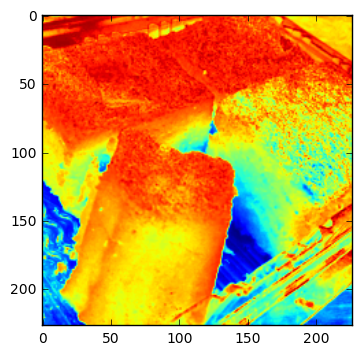

In [17]:
plt.imshow(X_test[4, 0])
plt.show()

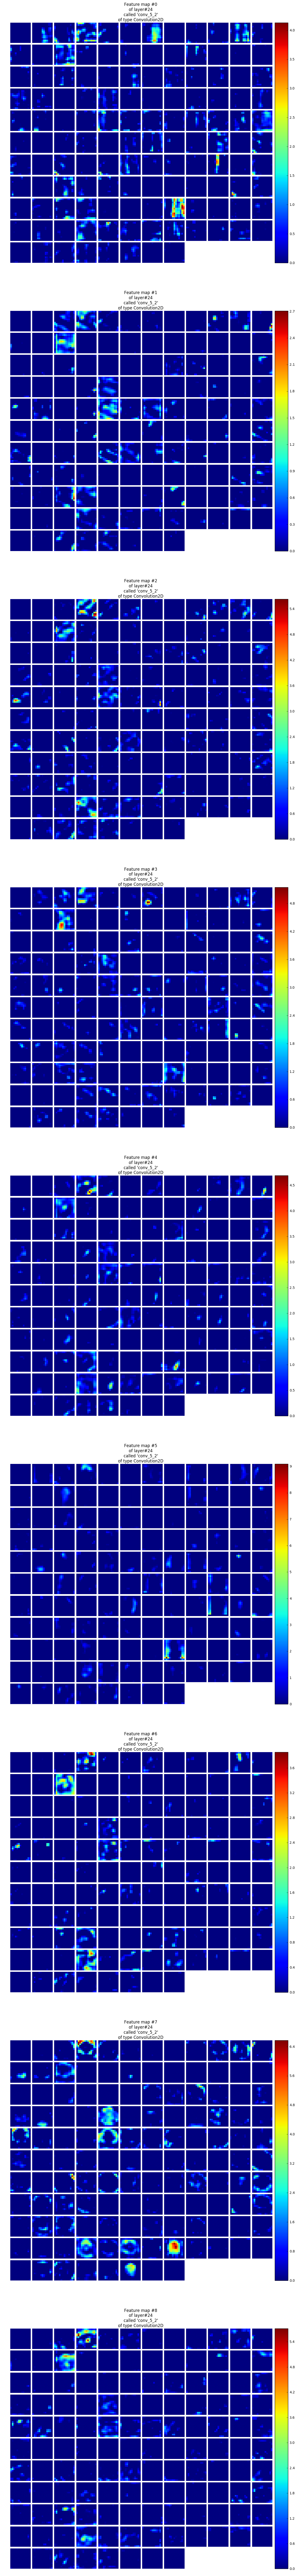

In [66]:
from kerastoolbox.visu import plot_feature_map

images = X_test[:9]
_ = plot_feature_map(model, X=images, layer_id=26, n_columns=1, n=254, cmap=None)
plt.show()